<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/I_JEPA_down.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title data
import torch
import torchvision
import torchvision.transforms as transforms
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor(),])
# transform = transforms.Compose([transforms.RandomResizedCrop((32,32), scale=(.3,1.)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
batch_size = 64 # 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_loader) # get some random training images
# images, labels = next(dataiter)
# print(images.shape) # [batch, 3, 32, 32]
# imshow(torchvision.utils.make_grid(images))


100%|██████████| 170M/170M [00:19<00:00, 8.93MB/s]


## vit

torch.Size([2, 4, 64, 64])
(3, 32, 64)


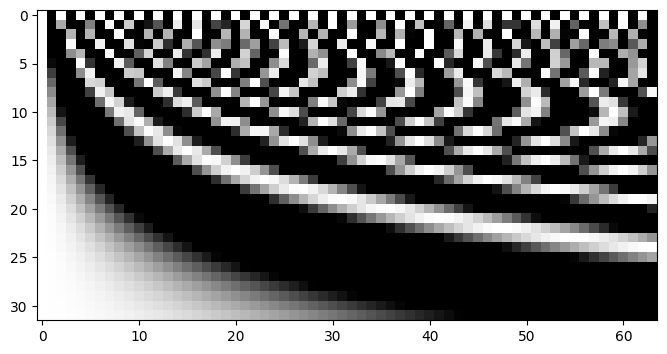

In [2]:
# @title RoPE
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def RoPE(dim, seq_len=512, top=torch.pi, base=1000):
    theta = top / (base ** (torch.arange(0, dim, step=2) / dim))
    pos = torch.arange(seq_len).unsqueeze(-1)
    angles = (pos * theta)[None,...,None] # [seq_len, 1] * [dim//2] -> [1, seq_len, dim//2, 1]
    rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [1, seq_len, dim//2, 2] -> [1, seq_len, dim]
    return rot_emb


# class RoPE(nn.Module): # Rotary Positional Embeddings
#     def __init__(self, dim, seq_len=512, top=torch.pi, base=1000):
#         super().__init__()
#         self.dim, self.base = dim, base
#         theta = top / (base ** (torch.arange(0, dim, step=2) / dim))
#         pos = torch.arange(seq_len).unsqueeze(-1)
#         angles = (pos * theta)[None,None,...,None] # [seq_len, 1] * [dim//2] -> [1, 1, seq_len, dim//2, 1]
#         self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [1, 1, seq_len, dim//2, 2] -> [1, 1, seq_len, dim]

#     def forward(self, x): # [b,h,t,d]
#         seq_len = x.size(-2)
#         if self.rot_emb.shape[0] < seq_len: self.__init__(self.dim, seq_len, self.base)
#         return x * self.rot_emb#[:,:,:seq_len]


# @title proper rope
import math
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class RoPE(nn.Module):
    def __init__(self, dim, seq_len=512, top=torch.pi, base=1000):
    # def __init__(self, dim, seq_len=512, min_freq=1, max_freq=400, n_zero_freqs=0):
        super().__init__()
        speed = top / (base ** (torch.arange(0, dim, step=2) / dim)) # [dim//2]
        pos = torch.arange(seq_len).unsqueeze(-1) # [t,1]
        # speed = torch.cat([torch.zeros(n_zero_freqs), min_freq * (max_freq/min_freq) ** torch.linspace(0,1,dim//2-n_zero_freqs)]) # [dim//2]
        # pos = torch.linspace(0, 1, seq_len).unsqueeze(-1) # [t,1]

        theta = (speed*pos) # [t,1]*[dim//2]=[t,d//2]
        self.theta = theta
        cos, sin = torch.cos(theta), torch.sin(theta)
        self.affine = torch.stack([cos, -sin, sin, cos], dim=-1).unflatten(-1,(2,2)).to(device) # [t,d//2,4]-> [1,1,t,d//2,2,2]

    def forward(self, x): # [b,h,t,d]
        return (self.affine @ x.unflatten(-1, (-1,2)).unsqueeze(-1)).flatten(-3) # [1,1,t,d//2,2,2] @ [b,h,t,d//2,2,1] = [b,h,t,d]

dim=64
n_heads=4
seq_len=64
rope = RoPE(dim, seq_len, top=torch.pi, base=100)
# rope = RoPE(dim, seq_len, min_freq=1, max_freq=200, n_zero_freqs=0)

x = torch.rand(2, n_heads, seq_len, dim, device=device)
out = rope(x)
print(out.shape)

theta = rope.theta # [t,d//2]
sim = torch.cos(theta-theta[0].unsqueeze(0)).T
# print(sim.shape)

import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

import torchvision
imshow(torchvision.utils.make_grid(sim, nrow=dim//2))



class RotEmb(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, top=torch.pi, base=1000):
        super().__init__()
        self.theta = top / (base ** (torch.arange(0, dim, step=2, device=device) / dim))
        # self.theta = top / (base ** torch.linspace(0, 1, dim//2, device=device))

    def forward(self, pos): # [batch] in [0,1]
        angles = (pos.unsqueeze(-1) * self.theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return rot_emb.flatten(-2) # [seq_len, dim]

# emb = RotEmb(dim, top=torch.pi, base=1000)

# theta = emb.theta
# print(theta)
# pos = torch.arange(0,200,1)
# angles = (pos.unsqueeze(-1) * theta).T # [b,t]
# sim = torch.cos(angles-angles[:,0].unsqueeze(-1))
# print(sim.shape)

# imshow(torchvision.utils.make_grid(sim, nrow=dim//2))



In [3]:
# @title AttentionBlock
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

class SelfAttn(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.dim, self.n_heads = dim, n_heads
        d_head = dim//n_heads
        self.rope = RoPE(d_head, seq_len=64, top=torch.pi, base=1000)
        # self.rope = RoPE(d_head, seq_len=512, base=1000)
        # self.rope = RoPE2D(d_head, h=64, w=64, base=100)
        # self.rope[0] = 1 # id for smry h
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        # self.lin = nn.Linear(dim, dim)
        self.lin = zero_module(nn.Linear(dim, dim))

        self.scale = d_head**-.5

    # def forward(self, x): # [b,t,d]
    def forward(self, x, pos=None): # [b,t,d]
        q,k,v = self.qkv(x).unflatten(-1, (self.n_heads,-1)).transpose(1,2).chunk(3, dim=-1) # [b, t, n_heads, d_head] -> [b, n_heads, t, d_head]
        # q, k = self.rope(q), self.rope(k)
        if pos != None:
            # rope = self.rope[pos]
            # q, k = q*rope, k*rope
            q, k = self.rope(q, pos), self.rope(k, pos)

        # x = F.scaled_dot_product_attention(q,k,v, attn_mask=None) # https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html
        q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        x = q @ context # [b, n_heads, t, d_head]
        # # print('SelfAttn', x.shape)
        x = x.transpose(1,2).flatten(2)
        return self.lin(x)

class AttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, mult=4, drop=0.):
        super().__init__()
        self.d_model = d_model
        # self.norm = nn.RMSNorm(d_model, elementwise_affine=False) # LayerNorm RMSNorm
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.drop = nn.Dropout(drop)
        self.attn = SelfAttn(d_model, n_heads)
        act = nn.GELU() # ReLU GELU
        ff_dim=d_model*mult
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), act, nn.Dropout(drop), nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Dropout(drop), nn.Linear(ff_dim, d_model)
            nn.RMSNorm(ff_dim), act, nn.Dropout(drop), zero_module(nn.Linear(ff_dim, d_model))
            # nn.RMSNorm(d_model), nn.Dropout(drop), nn.Linear(d_model, ff_dim), act,
            # nn.RMSNorm(ff_dim), nn.Dropout(drop), nn.Linear(ff_dim, d_model)
        )

    # def forward(self, x): # [b,t,d]
    def forward(self, x, pos=None): # [b,t,d]
        # print('attnblk fwd',x.shape)
        # x = x + self.drop(self.attn(self.norm1(x)))
        x = x + self.drop(self.attn(self.norm1(x), pos))
        x = x + self.ff(x)
        # x = x + self.drop(self.ff(self.norm2(x)))
        return x


# class ViT(nn.Module):
#     # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
#     def __init__(self, patch_size, in_dim, d_model, out_dim=None, n_heads=4, nlayers=1, drop=0.):
#         super().__init__()
#         patch_size=2
#         self.embed = nn.Sequential(
#             # nn.Conv2d(in_dim, d_model, patch_size, patch_size), # like patch
#             # nn.Conv2d(in_dim, d_model, 7, 1, 7//2, bias=False)
#             # nn.Conv2d(in_dim, d_model, 7, 2, 7//2, bias=False), nn.MaxPool2d(3,2,1)
#             nn.Conv2d(in_dim, d_model, 7, 2, 7//2, bias=False), nn.BatchNorm2d(d_model), nn.ReLU(),
#             nn.Conv2d(d_model, d_model, 3, 2, 3//2, bias=False)
#             )
#         # self.embed.requires_grad=False
#         # self.pos_enc = RotEmb(d_model, top=1, base=10000)
#         self.pos_emb = nn.Parameter(torch.randn(1, 32*32, d_model)*.02)
#         # self.pos_emb = nn.Parameter(RoPE2D(dim=d_model, h=8, w=8, base=1000), requires_grad=False)

#         # self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=(32//patch_size)**2, base=10000), requires_grad=False)
#         self.transformer = nn.Sequential(*[AttentionBlock(d_model, d_model, n_heads) for _ in range(nlayers)])
#         self.transformer = Seq(*[AttentionBlock(d_model, d_model, n_heads) for _ in range(nlayers)])
#         self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
#         self.lin = nn.Linear(d_model, out_dim) if out_dim and out_dim != d_model else None

#     def forward(self, x, context_indices=None): # [batch, num_context_toks, 3], [batch, num_context_toks] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
#         x = self.embed(x).flatten(2).transpose(1,2) # [b,c,h,w]->[b,h*w,c] # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
#         # x = self.pos_enc(x)
#         # print("TransformerModel",x.shape, self.pos_emb.shape)
#         # x = x + self.pos_emb[:,:x.shape[1]]
#         # if context_indices != None: x = x[torch.arange(x.shape[0]).unsqueeze(-1), context_indices] # [batch, num_context_toks, d_model]
#         # x = self.transformer(x)

#         x = self.transformer(x, context_indices)
#         out = self.norm(x)
#         if self.lin: out = self.lin(out)
#         return out


# d_model = 64
# in_dim = 3
# patch_size = 2
# # model = ViT(patch_size, in_dim, d_model, n_heads=4, nlayers=4, drop=0.).to(device)
# model = ViT(patch_size, in_dim, d_model, n_heads=4, nlayers=1, drop=0.).to(device)
# print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 27584
# x = torch.rand((5, in_dim, 32, 32), device=device)
# out = model(x)
# print(out.shape)




In [ ]:
# @title ssd me
# https://goombalab.github.io/blog/2024/mamba2-part4-systems/
# https://tridao.me/blog/2024/mamba2-part3-algorithm/
# # https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/triton/ssd_combined.py
import torch
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def segsum(x): # [...,c] # Naive segment sum calculation. exp(segsum(A)) produces a 1-SS matrix, which is equivalent to a scalar SSM.
    T = x.size(-1)
    x_cumsum = torch.cumsum(x, dim=-1)
    x_segsum = x_cumsum.unsqueeze(-1) - x_cumsum.unsqueeze(-2) # [...,c,c] # vert-hori
    mask = torch.triu(torch.ones(T, T, device=x.device, dtype=bool), diagonal=1)
    return x_segsum.masked_fill(mask, -torch.inf) # [...,c,c]

# def ssd(X, A, B, C, h0=None, b_ind=None, chunk=64): # X:[b,h,t,d], A:[b,h,t], B/C:[b,h,t,s], h0:[b,h,d,s], b_ind:[b]
def ssd(X, A, B, C, h0=None, msk=None, b_ind=None, chunk=64): # X:[b,h,t,d], A:[b,h,t], B/C:[b,h,t,s], h0:[b,h,d,s], msk:[b,t], b_ind:[b]
    # print('ssd', X.dtype, A.dtype, B.dtype)
    # assert X.dtype == A.dtype == B.dtype == C.dtype
    assert X.shape[:-1] == A.shape == B.shape[:-1]
    assert h0==None or b_ind==None
    # print('ssd', X.shape, A.shape, B.shape)
    if b_ind!=None: A[:,:,b_ind[1:-1]] = 0 # at boundaries, A=0
    if X.shape[2] % chunk != 0: X, A, B, C = [x.unsqueeze(2) for x in (X, A, B, C)]
    else: X, A, B, C = [x.unflatten(2, (-1,chunk)) for x in (X, A, B, C)] # [b,h,t/c,c(,d/s)]

    # 1. Compute the output for each intra-chunk (diagonal blocks)
    L = torch.exp(segsum(A)) # [b,h,t/c,c,c]
    # if msk!=None: L[msk] = 0 # L = L.masked_fill(msk, 0)
    if msk!=None: # this only saves computation from ssd. full info leakage, full compute in in_proj
        b,h,l,c,c = L.shape
        assert msk.shape==(b,l*c)
        msk = msk.reshape(b,1,l,c)
        msk = msk.unsqueeeze(-2) | msk.unsqueeze(-1) # [b,1,t/c,c,c]
        L[msk] = 0 # L = L.masked_fill(msk, 0)
    Y_diag  = torch.einsum("...cs,...ks,...ck,...kd->...cd", C, B, L, X) # bhlcs,bhlks,bhlck,bhlkd->bhlcd # full CA...ABX? for chunks

    # 2. Compute the state for each intra-chunk # (right term of low-rank factorization of off-diagonal blocks; B terms)
    A_cumsum = torch.cumsum(A, dim=-1) # [b,h,t/c,c]
    decay_states = torch.exp((A_cumsum[...,-1:] - A_cumsum)) # [b,h,t/c,c] # Ai+1...T
    states = torch.einsum("...cs,...c,...cd->...ds", B, decay_states, X) # bhlcs,bhlc,bhlcd->bhlds # BiXiAi+1...T

    # 3. Compute the inter-chunk SSM recurrence; produces correct SSM states at chunk boundaries # (middle term of factorization of off-diag blocks; A terms)
    if h0==None: h0 = torch.zeros_like(states[:,:,0], device=states.device) # [b,h,d,s]
    states = torch.cat([h0.unsqueeze(2), states], dim=2) # [b,1+t/c,h,d,s] # h0,hc,h2c,...,ht
    decay_chunk = torch.exp(segsum(F.pad(A_cumsum[...,-1], (1,0)))) # [b,h,1+t/c]-> # [b,h,1+t/c,1+t/c] # 1,A1...1t/c,A1t/c+1...2t/c,...,A(c-1)t/c...At
    new_states = torch.einsum("...tl,...lds->...tds", decay_chunk, states) # bhtl,bhlds->bhtds # h0, BiXi/A1...i-1,

    # 4. Compute state -> output conversion per chunk # (left term of low-rank factorization of off-diagonal blocks; C terms)
    Y_off = torch.einsum('...cs,...ds,...c->...cd', C, new_states[:,:,:-1], torch.exp(A_cumsum)) # bhlcs,bhlds,bhlc->bhlcd # offset for each chunk # C1h0A1, Ci BiXi/A1...i-1,
    Y = (Y_diag+Y_off).flatten(2,3)
    return Y, new_states[:,:,-1] # [b,t,h,d], [b,h,d,s]


In [ ]:
# @title Hydra one BCdt
# https://github.com/goombalab/hydra/blob/main/hydra/modules/hydra.py
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

# @torch.compile()
class Hydra(nn.Module):
    # def __init__(self, d_model, expand=2, n_heads=8, n_groups=8, d_state=8, d_conv=7):
    def __init__(self, d_model, expand=3, n_heads=8, n_groups=8, d_state=8, d_conv=7):
    # def __init__(self, d_model, expand=4, n_heads=8, n_groups=8, d_state=8, d_conv=7):
        super().__init__()
        n_groups = min(n_heads, n_groups)
        self.d_model, self.n_groups, self.d_state, self.d_conv = d_model, n_groups, d_state, d_conv
        self.d_inner = expand * self.d_model
        self.n_heads, self.d_head = n_heads, self.d_inner//n_heads

        self.in_proj = nn.Linear(self.d_model, 2* self.d_inner + 2*self.n_groups*self.d_state + self.n_heads, bias=False) # z,x,B,C,dt
        conv_dim = self.d_inner + 2*self.n_groups*self.d_state # for x,B,C
        self.conv1d = nn.Conv1d(conv_dim, conv_dim, kernel_size=d_conv, groups=conv_dim, padding=d_conv//2, bias=True)
        # self.conv1d = nn.Conv1d(conv_dim, conv_dim, kernel_size=d_conv, groups=conv_dim, padding=d_conv-1, bias=True)
        # self.conv1d.weight._no_weight_decay = True
        self.act = nn.SiLU()

        # self.h0 = nn.Parameter(torch.zeros(self.n_heads, self.d_head, self.d_state))
        # self.h0._no_weight_decay = True
        dt_min, dt_max = .001, .1
        dt = torch.exp(torch.rand(self.n_heads) * (math.log(dt_max)-math.log(dt_min)) + math.log(dt_min)).clamp(min=1e-4)
        self.dt_bias = nn.Parameter(dt + torch.log(-torch.expm1(-dt))) # Inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        self.dt_bias._no_weight_decay = True
        # A = torch.empty(self.n_heads, dtype=torch.float32).uniform_(1,16) # og
        A = torch.empty(self.n_heads).uniform_(1,16)
        # A = torch.ones(self.n_heads, dtype=torch.float32)
        self.A_log = nn.Parameter(torch.log(A))
        self.A_log._no_weight_decay = True

        self.D = nn.Linear(self.d_inner, self.n_heads)
        # nn.init.constant_(self.D.weight, 1)
        self.D.bias._no_weight_decay = True

        self.norm = nn.RMSNorm(self.d_inner)
        self.out = zero_module(nn.Linear(self.d_inner, self.d_model, bias=False))

    # def forward(self, u, h=None): # [b,t,d]
    # def forward(self, u, h=None, b_ind=None): # [b,t,d]
    def forward(self, u, h=None, ctx_ind=None, b_ind=None): # [b,t,d]
        b = u.shape[0]
        # print('Hydra u', u.shape)
        # print('Hydra u', u.dtype)
        A = -torch.exp(self.A_log) # [n_heads]
        z, xBC, dt = self.in_proj(u).split([self.d_inner, self.d_inner + 2*self.n_groups*self.d_state, self.n_heads], dim=-1)
        dt = torch.cat((dt, torch.flip(dt,(1,))), dim=0) # [b,t,h]->[2b,t,h]
        dt = F.softplus(dt+self.dt_bias) # [2b,t,h]+[h]
        xBC = self.act(self.conv1d(xBC.transpose(-2,-1)).transpose(-2,-1))  # [b,t, d_inner + 2* n_groups*d_state]
        x, BC = xBC.split([self.d_inner, 2*self.n_groups*self.d_state], dim=-1)

        x_og = x # [b,t,inr]
        x = torch.cat((x, torch.flip(x,(1,))), dim=0).unflatten(-1, (self.n_heads, self.d_head)) # [2b,t,inr]->[2b,t,h,d]
        B, C = torch.cat((BC, torch.flip(BC,(1,))), dim=0).chunk(2, dim=-1) # [b,t,2gs]->[2b,t,2gs]->[2b,t,gs]
        B, C = B.unflatten(-1, (self.n_groups, self.d_state)), C.unflatten(-1, (self.n_groups, self.d_state)) # x:[2b,t,h,d], B/C:[2b,t,g,s]
        h_g = self.n_heads//self.n_groups
        if h_g>1: B, C = B.repeat_interleave(h_g, dim=-2), C.repeat_interleave(h_g, dim=-2) # [b,t,g,s]->[b,t,h,s]
        x, B, C, dt = [a.transpose(1,2) for a in (x, B, C, dt)] # X:[b,h,t,d], B/C:[b,h,t,s], dt:[b,h,t]

        # h0 = self.h0.expand(u.size(0),-1,-1,-1) # [b,n,d,s]
        # print('x dt a b', x.shape, dt.shape, A.shape, B.shape)
        y, h = ssd(x*dt.unsqueeze(-1), A.unsqueeze(-1)*dt, B, C, h, b_ind=b_ind, chunk=64) # 256
        y = y.transpose(1,2).flatten(2) # [2b,t,d]/[1,2b*t,d]

        y = torch.roll(y, shifts=1, dims=1) # 123...l -> l12...l-1
        y[:,0] = 0 # 012...l-1
        y = y[:b] + torch.flip(y[b:], (1,)) + x_og * self.D(x_og).repeat(1,1,self.d_head) # [b,t,h*inr]

        y = self.norm(y * self.act(z)) # [b,t,d_inner] # norm(x)*silu(z) if norm_before_gate, else norm(x*silu(z)) # https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/triton/layernorm_gated.py#L18
        # y = self.norm(y) * self.act(z)
        out = self.out(y)
        # return out, h # [b,t,in]
        return out # [b,t,in]


b,t,d_model=5,256,32
# b,t,d_model=5,7,32
u = torch.randn(b,t,d_model, device=device)
model = Hydra(d_model).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 59850
# out, h = model(u)
out = model(u)
# h0 = torch.randn(b, model.n_heads, model.d_head, model.d_state)
# print(out.shape)
# print(out.shape, h.shape)
# print(out[0,-3:,:5], h[0,:2,:5,:5])
# out, h = model(u, h)

print(out.shape)
# print(out[0,-3:,:5], h[0,:2,:5,:5])

# noroll is still valid
# increase d_state to d_model*expand//n_groups? = d_inner//n_groups
# causal conv by slicing

# dt=dt*step then unk&step=1
# zoh(step then unk&step=1
# x=x+pos_emb then unk+pos_emb (same as trans)
# x=rope(x) then rope(unk) (attn pos)
# unk[ctx]=x (+pos?) (no drop toks)


In [4]:
# @title ViT
import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        self._kwargs = [[name for name, p in inspect.signature(layer.forward).parameters.items()] for layer in self]

    def forward(self, x, *args, **kwargs):
        for layer, _kwargs in zip(self, self._kwargs):
            x = layer(x, *args, **{k: v for k, v in kwargs.items() if k in _kwargs})
        return x

class ViT(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
    def __init__(self, patch_size, in_dim, d_model, out_dim=None, n_heads=4, nlayers=1, drop=0.):
        super().__init__()
        patch_size=2
        self.embed = nn.Sequential(
            # nn.Conv2d(in_dim, d_model, patch_size, patch_size), # like patch
            # nn.Conv2d(in_dim, d_model, 7, 1, 7//2, bias=False)
            # nn.Conv2d(in_dim, d_model, 7, 2, 7//2, bias=False), nn.MaxPool2d(3,2,1)
            nn.Conv2d(in_dim, d_model, 7, 2, 7//2, bias=False), nn.BatchNorm2d(d_model), nn.ReLU(),
            nn.Conv2d(d_model, d_model, 3, 2, 3//2, bias=False)
            )
        # self.embed.requires_grad=False
        # self.pos_enc = RotEmb(d_model, top=1, base=10000)
        self.pos_emb = nn.Parameter(torch.randn(1, 32*32, d_model)*.02)
        # self.pos_emb = nn.Parameter(RoPE2D(dim=d_model, h=8, w=8, base=1000), requires_grad=False)

        # self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=(32//patch_size)**2, base=10000), requires_grad=False)
        self.transformer = nn.Sequential(*[AttentionBlock(d_model, d_model, n_heads) for _ in range(nlayers)])
        # self.transformer = Seq(*[Hydra(d_model, n_heads) for _ in range(nlayers)])
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.lin = nn.Linear(d_model, out_dim) if out_dim and out_dim != d_model else None

    def forward(self, x, context_indices=None): # [b,ctx,3], [b,ctx] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        x = self.embed(x).flatten(2).transpose(1,2) # [b,c,h,w]->[b,h*w,c] # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        # x = self.pos_enc(x)
        # print("TransformerModel",x.shape, self.pos_emb.shape)
        # print("TransformerModel",x.shape)
        x = x + self.pos_emb[:,:x.shape[1]]
        # if context_indices != None: x = x[torch.arange(x.shape[0]).unsqueeze(-1), context_indices] # [batch, num_context_toks, d_model]
        # x = self.transformer(x)

        if context_indices != None:
            # print('vit fwd', context_indices)
            # print('vit transformer',x[torch.arange(x.shape[0]).unsqueeze(-1), context_indices].shape, context_indices.shape)
            # x = self.transformer(x[torch.arange(x.shape[0]).unsqueeze(-1), context_indices], context_indices)
            x = self.transformer(x[torch.arange(x.shape[0]).unsqueeze(-1), context_indices])
        else: x = self.transformer(x)

        out = self.norm(x)
        if self.lin: out = self.lin(out)
        return out

d_model = 64
in_dim = 3
patch_size = 2
# model = ViT(patch_size, in_dim, d_model, n_heads=4, nlayers=4, drop=0.).to(device)
model = ViT(patch_size, in_dim, d_model, n_heads=4, nlayers=1, drop=0.).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 27584
x = torch.rand((5, in_dim, 32, 32), device=device) # [b,c,h,w]
out = model(x)
print(out.shape)


162112
torch.Size([5, 64, 64])


tensor([455, 583, 382, 543, 509, 473, 413, 507, 336, 459, 567, 497, 464, 591,
        528, 523])
tensor([309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309,
        309, 309])


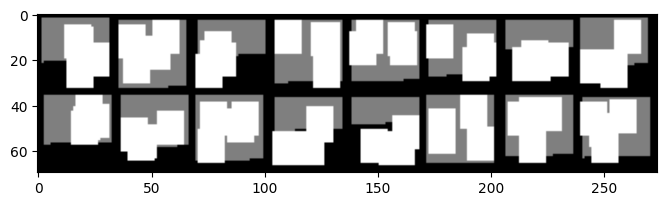

In [5]:
# @title masks
import torch
import numpy as np
import matplotlib.pyplot as plt

# def multiblock(seq, min_s, max_s, M=1):
#     mask_len = torch.rand(1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
#     mask_pos = torch.rand(M) * (1 - mask_len) # in (0, 1 - mask_len)
#     mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
#     indices = torch.arange(seq).unsqueeze(0) # [1, seq]
#     target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [M, seq]
#     return target_mask


# def multiblock2d(hw=(8,8), scale=(.15,.2), aspect_ratio=(.75,1.5), M=1):
#     mask_aspect = torch.rand(1) * (aspect_ratio[1] - aspect_ratio[0]) + aspect_ratio[0] # in (min_s, max_s) # all blocks same size
#     mask_scale = torch.rand(1) * (scale[1] - scale[0]) + scale[0] # in (min_s, max_s) # all blocks same size
#     h = (mask_scale/mask_aspect)**.5# h*(h*aspect) = scale
#     w = h * mask_aspect
#     h_pos, w_pos = torch.rand(M)*(1-w), torch.rand(M)*(1-h) # in (0, 1 - mask_len)
#     h_len, h_pos = (h*hw[0]).int(), h_pos*hw[0]
#     w_len, w_pos = (w*hw[1]).int(), w_pos*hw[1]
#     h_ind, w_ind = torch.arange(hw[0]).unsqueeze(0), torch.arange(hw[1]).unsqueeze(0) # [1, seq]
#     h_mask = (h_ind>=h_pos.unsqueeze(-1)) & (h_ind<(h_pos+h_len).unsqueeze(-1)) # [M, seq]
#     w_mask = (w_ind>=w_pos.unsqueeze(-1)) & (w_ind<(w_pos+w_len).unsqueeze(-1)) # [M, seq]
#     target_mask = h_mask.unsqueeze(-1) & w_mask.unsqueeze(-2) # [M, seq, seq]
#     return target_mask

# # https://arxiv.org/pdf/2210.07224
# def randpatch(seq, mask_size=8, gamma=0.9): # num patches of seq, mask patch size, masking ratio
#     # mask = torch.rand(seq//mask_size)<gamma
#     length = seq//mask_size
#     g = torch.normal(gamma, std=.1, size=(1,)).clamp(.5,.9)
#     # g = gamma
#     idx = torch.randperm(length)[:int(length*g)]
#     mask = torch.zeros(length, dtype=bool)
#     mask[idx] = True
#     mask = mask.repeat_interleave(mask_size, dim=-1)
#     return mask # [seq] , True -> mask


# import torch
# def apply_masks(x, mask): # [b,t,d], [mask_size] # https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
#     mask_keep = mask.unsqueeze(-1).repeat(x.size(0), 1, x.size(-1)) # [batch,T,dim]
#     return torch.gather(x, dim=1, index=mask_keep) # [batch,mask_size,dim]


# @title ijepa multiblock next
# https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
import math
from multiprocessing import Value
import torch

class MaskCollator(object):
    def __init__(self, hw=(224, 224), enc_mask_scale=(.85,1), pred_mask_scale=(.15,.2), aspect_ratio=(.75,1.25),
        nenc=1, npred=2, min_keep=4, allow_overlap=False):
        super().__init__()
        self.height, self.width = hw
        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.aspect_ratio = aspect_ratio
        self.nenc = nenc
        self.npred = npred
        self.min_keep = min_keep  # minimum number of patches to keep
        self.allow_overlap = allow_overlap  # whether to allow overlap b/w enc and pred masks

    def _sample_block_size(self, scale, aspect_ratio_scale):
        _rand = torch.rand(1).item()
        # -- Sample block scale
        min_s, max_s = scale
        mask_scale = min_s + _rand * (max_s - min_s)
        max_keep = int(self.height * self.width * mask_scale) # num patches to keep
        # -- Sample block aspect-ratio
        min_ar, max_ar = aspect_ratio_scale
        aspect_ratio = min_ar + _rand * (max_ar - min_ar)
        # -- Compute block height and width (given scale and aspect-ratio)
        h = int(round(math.sqrt(max_keep * aspect_ratio)))
        w = int(round(math.sqrt(max_keep / aspect_ratio)))
        while h >= self.height: h -= 1 # crop mask to be smaller than img
        while w >= self.width: w -= 1
        return (h, w)

    def _sample_block_mask(self, b_size, acceptable_regions=None):
        h, w = b_size
        def constrain_mask(mask, tries=0):
            """ Helper to restrict given mask to a set of acceptable regions """
            N = max(int(len(acceptable_regions)-tries), 0)
            for k in range(N):
                mask *= acceptable_regions[k]
        # -- Loop to sample masks until we find a valid one
        tries = 0
        timeout = og_timeout = 20
        valid_mask = False
        while not valid_mask:
            # -- Sample block top-left corner
            top = torch.randint(0, self.height - h, (1,))
            left = torch.randint(0, self.width - w, (1,))
            mask = torch.zeros((self.height, self.width), dtype=torch.int32)
            mask[top:top+h, left:left+w] = 1
            # -- Constrain mask to a set of acceptable regions
            if acceptable_regions is not None:
                constrain_mask(mask, tries)
            mask = torch.nonzero(mask.flatten())
            # -- If mask too small try again
            valid_mask = len(mask) > self.min_keep
            if not valid_mask:
                timeout -= 1
                if timeout == 0:
                    tries += 1
                    timeout = og_timeout
        mask = mask.squeeze()
        # --
        mask_complement = torch.ones((self.height, self.width), dtype=torch.int32)
        mask_complement[top:top+h, left:left+w] = 0
        # --
        return mask, mask_complement

    def __call__(self, B):
        '''
        Create encoder and predictor masks when collating imgs into a batch
        # 1. sample enc block (size + location) using seed
        # 2. sample pred block (size) using seed
        # 3. sample several enc block locations for each image (w/o seed)
        # 4. sample several pred block locations for each image (w/o seed)
        # 5. return enc mask and pred mask
        '''
        p_size = self._sample_block_size(scale=self.pred_mask_scale, aspect_ratio_scale=self.aspect_ratio)
        e_size = self._sample_block_size(scale=self.enc_mask_scale, aspect_ratio_scale=(1., 1.))

        collated_masks_pred, collated_masks_enc = [], []
        min_keep_pred = self.height * self.width
        min_keep_enc = self.height * self.width
        for _ in range(B):

            masks_p, masks_C = [], []
            for _ in range(self.npred):
                mask, mask_C = self._sample_block_mask(p_size)
                masks_p.append(mask)
                masks_C.append(mask_C)
                min_keep_pred = min(min_keep_pred, len(mask))
            collated_masks_pred.append(masks_p)

            acceptable_regions = masks_C
            try:
                if self.allow_overlap:
                    acceptable_regions= None
            except Exception as e:
                print(f'Encountered exception in mask-generator {e}')

            masks_e = []
            for _ in range(self.nenc):
                mask, _ = self._sample_block_mask(e_size, acceptable_regions=acceptable_regions)
                masks_e.append(mask)
                min_keep_enc = min(min_keep_enc, len(mask))
            collated_masks_enc.append(masks_e)
        collated_masks_pred = [[cm[:min_keep_pred] for cm in cm_list] for cm_list in collated_masks_pred]
        collated_masks_pred = torch.utils.data.default_collate(collated_masks_pred)
        # --
        collated_masks_enc = [[cm[:min_keep_enc] for cm in cm_list] for cm_list in collated_masks_enc]
        collated_masks_enc = torch.utils.data.default_collate(collated_masks_enc)
        return collated_masks_enc, collated_masks_pred

mask_collator = MaskCollator(hw=(32,32), enc_mask_scale=(.85, 1.), pred_mask_scale=(.15, .2), aspect_ratio=(.75, 1.5),
        nenc=1, npred=4, min_keep=4,
        # allow_overlap=True)
        allow_overlap=False)

b=16
collated_masks_enc, collated_masks_pred = mask_collator(b)
ctx_index, trg_index = torch.stack(collated_masks_enc).squeeze(0), torch.stack(collated_masks_pred).transpose(0,1).flatten(1).unique(dim=1) # [num_msk, b,num_tok]->[b,num_tok] # [64, 65], [64, 32]

def imshow(img):
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# imshow(mask)

mask = torch.zeros(b ,32*32)
mask[torch.arange(b).unsqueeze(-1), trg_index] = 1
mask[torch.arange(b).unsqueeze(-1), ctx_index] = .5
mask = mask.reshape(b,1,32,32)
print((mask==1).flatten(1).sum(-1))
print((mask==.5).flatten(1).sum(-1))
import torchvision
imshow(torchvision.utils.make_grid(mask, nrow=8))


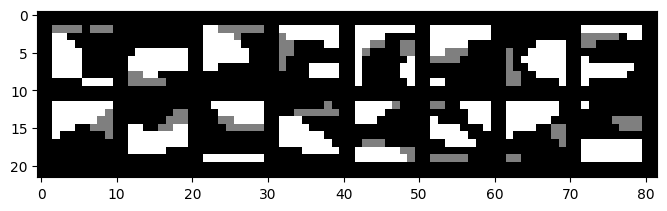

In [19]:
# @title Random Fourier Features noise
import math
import torch

# Random Fourier Features: ∑_k] a_k * cos(ω_k ⋅ x + 𝜙_k)
def rff_noise(x, out_dim, n_freqs=64, scale=1): # [...,n_Dim]
    space, in_dim, device = x.shape[:-1], x.shape[-1], x.device
    x = x.flatten(0,-2) # [N,in]
    w = torch.randn(out_dim, n_freqs, in_dim, device=device) * scale
    phi = torch.empty(out_dim, n_freqs, device=device).uniform_(0,2*math.pi)
    a = torch.randn(out_dim, n_freqs, device=device) / math.sqrt(n_freqs)
    y = torch.cos(torch.einsum("ofd,...d->...of", w, x) + phi) # [N,out,freq]
    return torch.einsum("of,...of->...o", a, y).unflatten(0,space) # [...,out]

def rffmask2d(bhw, ctx_scale=(.85,1.), trg_scale=(.6,.8), chaos=[1,.5], sort=False): # ctx_scale > trg_scale
# def rffmask2d(bhw, ctx_scale=(.05,.5), trg_scale=(.2,.8), chaos=[1,.5], sort=False): # ctx_scale > trg_scale
    b,h,w = bhw
    ix, iy = torch.linspace(0, chaos[0], h), torch.linspace(0, chaos[1], w)
    x = torch.stack(torch.meshgrid(ix, iy, indexing="ij"), dim=-1) # [t,h,w,b] / [h,w,b]
    noise = rff_noise(x, b, n_freqs=16).flatten(0,-2).T # [h,w,b]->[h*w,b]->[b,h*w]
    ctx_mask_scale = torch.rand(1) * (ctx_scale[1] - ctx_scale[0]) + ctx_scale[0] # in (min_s, max_s) # all blocks same size
    trg_mask_scale = torch.rand(1) * (trg_scale[1] - trg_scale[0]) + trg_scale[0]
    seq = h*w
    ctx_len, trg_len = int(seq*ctx_mask_scale), int(seq*trg_mask_scale)
    # print(ctx_len, trg_len)
    # ctx_len = ctx_len - trg_len
    ctx_len = min(ctx_len, seq-trg_len)

    _, trg_ind = torch.topk(noise, trg_len, dim=1, sorted=sort)
    noise = rff_noise(x, b, n_freqs=16).flatten(0,-2).T
    noise.scatter_(1, trg_ind, -10).flatten()
    _, ctx_ind = torch.topk(noise, ctx_len, dim=1, sorted=sort)
    return ctx_ind, trg_ind

b=16
hw=(8,8)
# cxt_inds, trg_inds = rffmask2d((b,)+hw, ctx_scale=(.85,1.), trg_scale=(.2,.8), chaos=[3,1], sort=True)
# cxt_inds, trg_inds = rffmask2d((b,)+hw, ctx_scale=(.85,1.), trg_scale=(.2,.8), chaos=[1,.5], sort=True)
cxt_inds, trg_inds = rffmask2d((b,)+hw, ctx_scale=(.05,.5), trg_scale=(.2,.8), chaos=[3,1], sort=True)

import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# imshow(mask)

mask = torch.zeros(b ,math.prod(hw))
# mask = torch.ones(b ,32*32)*.3
mask[torch.arange(b).unsqueeze(-1), trg_inds] = 1
mask[torch.arange(b).unsqueeze(-1), cxt_inds] = .5
# print((mask==1).sum(1))
# print((mask==.5).sum(1))
mask = mask.reshape(b,1,*hw)
import torchvision
imshow(torchvision.utils.make_grid(mask, nrow=8))


In [6]:
# @title Transformer Predictor
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TransformerPredictor(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, n_heads=4, nlayers=1, drop=0.):
        super().__init__()
        self.embed = nn.Linear(in_dim, d_model)# if in_dim != d_model else None
        # self.pos_enc = RotEmb(d_model, top=1, base=10000)
        self.pos_emb = nn.Parameter(torch.randn(1, 32*32, d_model)*0.02)
        # self.pos_emb = nn.Parameter(RoPE2D(dim=d_model, h=8, w=8, base=1000), requires_grad=False)
        # self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=32*32, base=10000), requires_grad=False)

        # self.transformer = nn.Sequential(*[AttentionBlock(d_model, d_model, n_heads) for _ in range(nlayers)])
        self.transformer = Seq(*[AttentionBlock(d_model, n_heads) for _ in range(nlayers)])
        # self.transformer = Seq(*[Hydra(d_model, n_heads) for _ in range(nlayers)])

        self.cls = nn.Parameter(torch.randn(1,1,d_model)*.02) # randn zeros
        out_dim = out_dim or d_model
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.lin = nn.Linear(d_model, out_dim)# if out_dim != d_model else None

    def forward(self, x, context_indices, trg_indices): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        x = self.embed(x) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = x.shape
        # x = x * self.pos_enc(context_indices)
        # x = x + self.pos_emb[0,context_indices]

        # # pred_tokens = self.cls * self.pos_enc(trg_indices) # [M, num_trg_toks, d_model]
        # pred_tokens = self.cls + self.pos_emb[0,trg_indices]
        # # print("pred fwd", x.shape, pred_tokens.shape)
        # x = torch.cat([x, pred_tokens], dim=1) # [batch, seq_len+num_trg_toks, d_model]
        # out = self.transformer(x)

        # x = torch.cat([x, self.cls.expand(*trg_indices.shape,-1)], dim=1) # [batch, num_ctx_toks+num_trg_toks, d_model]
        # out = self.transformer(x, torch.cat([context_indices, trg_indices], dim=-1))

        x = torch.cat([x, self.cls.expand(*trg_indices.shape,-1)], dim=1) # [batch, num_ctx_toks+num_trg_toks, d_model]
        _, idx = torch.sort(torch.cat([context_indices, trg_indices], dim=-1)) # [b,ctx+trg]
        x = x[torch.arange(x.shape[0]).unsqueeze(-1), idx]
        out = self.transformer(x)

        out = self.norm(out)
        out = out[:,seq:] # [batch, num_trg_toks, d_model]
        out = self.lin(out)
        # print("pred fwd", out.shape)
        return out # [seq_len, batch_size, ntoken]


In [40]:
# @title IJEPA
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

@torch.compile
class IJEPA(nn.Module):
    def __init__(self, in_dim=3, d_model=64, out_dim=None, nlayers=1, n_heads=4):
        super().__init__()
        self.out_dim = out_dim = out_dim or d_model
        self.patch_size = 4 # 4
        self.student = ViT(self.patch_size, in_dim, d_model, out_dim=out_dim, n_heads=n_heads, nlayers=nlayers, drop=0.)
        self.predicter = TransformerPredictor(out_dim, d_model//2, out_dim, n_heads=4, nlayers=1, drop=0.)
        import copy
        self.teacher = copy.deepcopy(self.student)
        self.teacher.requires_grad_(False)
        self.hw=(8,8) # (8,8) (32,32)
        # self.mask_collator = MaskCollator(self.hw, enc_mask_scale=(.85, 1.), pred_mask_scale=(.15, .2), aspect_ratio=(.75, 1.5), nenc=1, npred=4, min_keep=4, allow_overlap=False) # og

    def loss(self, x): #
        b,c,h,w = x.shape
        # collated_masks_enc, collated_masks_pred = self.mask_collator(b)
        # cxt_inds, trg_inds = torch.stack(collated_masks_enc).squeeze(0), torch.stack(collated_masks_pred).transpose(0,1).flatten(1).unique(dim=1) # [num_msk, b,num_tok]->[b,num_tok] # [64, 65], [64, 32]

        cxt_inds, trg_inds = rffmask2d((1,)+self.hw, ctx_scale=(.85,1.), trg_scale=(.2,.8), chaos=[3,1], sort=True)
        # cxt_inds, trg_inds = rffmask2d((1,)+self.hw, ctx_scale=(.05,.5), trg_scale=(.15,.2), chaos=[3,1], sort=True)
        # cxt_inds, trg_inds = simplexmask2d(hw, ctx_scale=(.85,1), trg_scale=(.7,.8), B=b, chaos=[3,.5])
        cxt_inds, trg_inds = cxt_inds.repeat(b,1), trg_inds.repeat(b,1)

        # zero_mask = torch.zeros(b ,*self.hw, device=device).flatten(1)
        # zero_mask[torch.arange(b).unsqueeze(-1), cxt_inds] = 1
        # x_ = x * F.interpolate(zero_mask.reshape(b,1,*self.hw), size=x.shape[2:], mode='nearest-exact') # zero masked locations
        # sx = self.student(x_, context_indices=cxt_inds) # [batch, num_context_toks, out_dim]

        sx = self.student(x, context_indices=cxt_inds) # [batch, num_context_toks, out_dim]
        # print('ijepa loss sx',sx.shape)
        sy_ = self.predicter(sx, context_indices=cxt_inds, trg_indices=trg_inds) # [batch*M, num_trg_toks, out_dim]
        sy_ = F.layer_norm(sy_, (sy_.size(-1),))
        with torch.no_grad():
            sy = self.teacher(x.detach()) # [batch, num_trg_toks, out_dim]
            # print('ijepa loss sy',sy.shape)
            sy = sy[torch.arange(sy.shape[0]).unsqueeze(-1), trg_inds] # [batch, num_context_toks, d_model] # nan bec len(trg_ind)==0 # print('loss sy',torch.isnan(sy).any())
            sy = F.layer_norm(sy, (sy.size(-1),))
        loss = F.mse_loss(sy, sy_)
        return loss

    def forward(self, x): # [b,t,3]
        out = self.student(x).mean(dim=1)
        return out

# min_s=0.15, max_s, M
# trg.15.2M4 C.85 1
# dont normalise data
# randmsk < simplex 1msk < multiblk
# teacher=trans ~? teacher=copy
# learn convemb
# lr pred,student: 3e-3/1e-2, 1e-3

# lr 1e-3 < 1e-2,1e-3? slower but dun plateau
# zeromsk impt, else closs start increasing
# l1rge trg helps delay increase?

# vit 1lyr 15.4sec 15.6
# hiera downsampling attn 20.5

# ijepa = IJEPA(in_dim=3, d_model=64, out_dim=64, nlayers=4, n_heads=4).to(device)
ijepa = IJEPA(in_dim=3, d_model=64, out_dim=64, nlayers=1, n_heads=8).to(device)
# ijepa = IJEPA(in_dim=3, d_model=32, out_dim=32, nlayers=1, n_heads=4).to(device)
optim = torch.optim.AdamW(ijepa.parameters(), lr=1e-3)#, weight_decay=0) # 1e-3?
# optim = torch.optim.AdamW([{'params': ijepa.student.parameters()},
# #     {'params': ijepa.predicter.parameters(), 'lr': 3e-3}], lr=1e-3, weight_decay=1e-2) # good 3e-3,1e-3 ; default 1e-2, 5e-2
#     {'params': ijepa.predicter.parameters(), 'lr': 1e-2}], lr=1e-3, weight_decay=1e-2)

# https://github.com/facebookresearch/ijepa/blob/main/configs/in1k_vith14_ep300.yaml
# d_model 1024,384
# depth 12,6/12
# wd 5e-2 - 4e-1
# adamw 1e-4 - 1e-3 - 1e-6
# ema 0.996-1

print(sum(p.numel() for p in ijepa.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in ijepa.parameters())) # 27584
# print(sum(p.numel() for p in ijepa.predicter.transformer_encoder.parameters() if p.requires_grad)) # 27584
# d_model^2 * nlayers

x = torch.rand((64,3,32,32), device=device)
out = ijepa.loss(x)
print(out.shape)

class Classifier(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super().__init__()
        self.classifier = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.classifier(x)
classifier = Classifier(ijepa.out_dim, 10).to(device)
coptim = torch.optim.SGD(classifier.parameters(), lr=1e-3)
# optim = torch.optim.AdamW([{'params': ijepa.parameters()}, {'params': classifier.parameters(), 'lr': 1e-3}], lr=1e-3)



245184
torch.Size([])


In [41]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="ijepa", config={"model": "res18",})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


closs,▇██▆▆▅▅▅▅▆▅▆▅▅▄▅▄▄▃▄▄▃▅▂▃▃▃▃▂▂▄▄▃▃▁▃▃▃▃▃
correct,▁▂▂▂▃▂▃▂▆▄▇▆█▅▅▆▆▅█▆▇▆▅▆▆▅▆▆▆█▆▆▇██▆▃▇▇▆
loss,█▂▁▂▁▂▁▁▁▂▁▂▂▁▂▂▁▂▃▁▁▁▁▃▂▂▂▃▂▃▁▁▂▃▂▁▁▁▃▂
closs,1.82904
correct,0.42188
loss,0.05904


In [ ]:
# @title strain ctrain test
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler()
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

def strain(model, dataloader, optim, scheduler=None): # train function with automatic mixed precision
    model.train()
    for i, (x, _) in enumerate(dataloader):
        x = x.to(device)#.to(torch.bfloat16) # [b,c,h,w] -> [b,h*w,c]
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            loss = model.loss(x)
        optim.zero_grad()
        scaler.scale(loss).backward()
        # scaler.unscale_(optim)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # 0.5
        scaler.step(optim)
        scaler.update()

        with torch.no_grad():
            m=0.999 # 0.99 m = next(momentum_scheduler)
            norms=[]
            for param_q, param_k in zip(model.student.parameters(), model.teacher.parameters()):
                param_k.data.mul_(m).add_((1.-m) * param_q.detach().data)

        # if scheduler is not None: scheduler.step()
        if i%10==0: print("strain",loss.item())
        try: wandb.log({"loss": loss.item()})
        except NameError: pass

        if i>=50: break
    writer.close()

def ctrain(model, classifier, dataloader, coptim, scheduler=None): # train function with automatic mixed precision
    model.eval()
    classifier.train()
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device) # [batch, ]
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            with torch.no_grad():
                sx = model(x).detach()
            y_ = classifier(sx)
            loss = F.cross_entropy(y_, y)
        coptim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(coptim)
        scaler.update()
        print("classify",loss.item())
        try: wandb.log({"closs": loss.item()})
        except NameError: pass
        if i>=10: break


def test(model, classifier, dataloader):
    model.eval()
    classifier.eval()
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device) # [batch, ]
        with torch.no_grad():
            sx = model(x)
            y_ = classifier(sx)
        correct = (y==y_.argmax(dim=1)).sum().item()
        print(correct/len(y))
        try: wandb.log({"correct": correct/len(y)})
        # try: wandb.log({"correct": correct/len(y), "rankme": rankme, "lidar": lidar})
        except NameError: pass
        if i>=10: break

import time
start = begin = time.time()
# for i in range(1):
for i in range(1000): # 1000
    print(i)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    strain(ijepa, train_loader, optim)
    ctrain(ijepa, classifier, train_loader, coptim)
    test(ijepa, classifier, test_loader)

    print('time:',time.time() - start, (time.time()-begin)/(i+1))
    start = time.time()


Streaming output truncated to the last 5000 lines.
classify 2.007080078125
classify 2.0814208984375
0.234375
0.3125
0.140625
0.140625
0.234375
0.21875
0.140625
0.171875
0.203125
0.25
0.1875
time: 2.4143049716949463 2.500626894934424
116
strain 0.04952884837985039
strain 0.06368880718946457
strain 0.08494727313518524
strain 0.05067498981952667
strain 0.07501504570245743
strain 0.15976302325725555
classify 2.041748046875
classify 2.19879150390625
classify 2.10382080078125
classify 2.0950927734375
classify 2.1217041015625
classify 2.093505859375
classify 2.1075439453125
classify 2.15362548828125
classify 2.1942138671875
classify 2.0794677734375
classify 2.055908203125
0.171875
0.265625
0.1875
0.171875
0.203125
0.15625
0.15625
0.234375
0.15625
0.171875
0.21875
time: 2.3960227966308594 2.4997373992561274
117
strain 0.07382393628358841
strain 0.04498496279120445
strain 0.21108299493789673
strain 0.05674690008163452
strain 0.05989784002304077
strain 0.08305159956216812
classify 2.117309570312

In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'

# # modelsd, optimsd = torch.load(folder+'SeqJEPA.pkl', map_location=device).values()
# modelsd, optimsd = torch.load('SeqJEPA.pkl', map_location=device).values()
# seq_jepa.load_state_dict(modelsd, strict=False)
# optim.load_state_dict(optimsd)

In [ ]:
checkpoint = {'model': ijepa.state_dict(), 'optimizer': optim.state_dict()}
torch.save(checkpoint, folder+'ijepa.pkl')
# torch.save(checkpoint, 'IJEPA.pkl')

## store

In [ ]:
# @title GoldenGateRoPE2d
import math
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class GoldenGateRoPE2d(nn.Module): # jerryxio.ng/posts/nd-rope
    def __init__(self, image_size, n_heads, n_freqs, min_freq=.8, max_freq=10, n_zero_freqs=0):
        super().__init__()
        intv = math.pi * (math.sqrt(5)-1)/2 # mod pi instead of 2pi # pi*(sqrt5+-1)/2 ; + and - are equivalent bec mod pi
        # intv = math.pi * (math.sqrt(5)-1) # https://en.wikipedia.org/wiki/Golden_angle
        speed = torch.cat([torch.zeros(n_zero_freqs), min_freq * (max_freq/min_freq) ** torch.linspace(0,1,n_freqs-n_zero_freqs)]).unsqueeze(-1) # [n_freqs,1] # og
        angle = torch.arange(n_heads*n_freqs).reshape(n_heads, n_freqs) * intv # [n_heads, n_freqs]
        direction = torch.stack([torch.cos(angle), torch.sin(angle)], dim=-1) # [n_heads, n_freqs, 2]
        h, w = image_size
        xlim, ylim = w/h, h/w
        y, x = torch.meshgrid(torch.linspace(-ylim, ylim, h), torch.linspace(-xlim, xlim, w), indexing="ij") # [h,w], y:row_num, x:col_num
        pos = torch.stack([x, y], dim=-1).reshape(-1,1,1,2) # [h*w,1,1,2] cartesian coords
        theta = (speed*direction*pos).sum(dim=-1) # [t,n_heads,n_freqs,2]->[t,n_heads,d_head]
        self.theta = theta
        cos, sin = torch.cos(theta), torch.sin(theta)
        self.affine = torch.stack([cos, -sin, sin, cos], dim=-1).transpose(0,1).reshape(1,n_heads,h*w,n_freqs,2,2).to(device) # [t,n_heads,n_freqs,4]->[1,n_heads,t,n_freqs,2,2]

    def forward(self, x): # [b,h,t,d]
        return (self.affine @ x.unflatten(-1, (-1,2)).unsqueeze(-1)).flatten(-3) # @ [b,h,t,d_head//2,2,1]

# /2 better
# speed [n_freqs,1] # og best
# w/h best
# rope < ggrope < learned

# image_size=(8,8)
image_size=(20,30)
# image_size=(90,120)
n_heads=4
n_freqs=6
ggrope = GoldenGateRoPE2d(image_size, n_heads, n_freqs)

# x = torch.rand(2, *image_size, n_heads, n_freqs*2)
x = torch.rand(2, n_heads, image_size[0]*image_size[1], n_freqs*2)
out = ggrope(x)
print(out.shape)
# # print(out[0])
# theta = ggrope.theta.flatten(-2).permute(2,0,1).unsqueeze(1) # [t,n_heads,d_head][b,1,h,w]
theta = ggrope.theta.flatten(-2).T.reshape(n_heads*n_freqs, 1, *image_size) # [t,n_heads,d_head]->[d,1,h,w]
cy, cx = image_size[0]//2, image_size[1]//2
sim = torch.cos(theta-theta[...,cy,cx][...,None,None]) # [b,1,h,w]
# sim = sim.unflatten(0, (n_heads, n_freqs)).mean(1)
# print(sim.shape)

import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.rcParams["figure.figsize"] = (8,8)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# bhwc

import torchvision
imshow(torchvision.utils.make_grid(sim, nrow=n_freqs))



In [ ]:
# @title RoPE pos
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class RoPE(nn.Module):
    def __init__(self, dim, seq_len=512, top=torch.pi, base=10000):
    # def __init__(self, dim, seq_len=512, min_freq=1, max_freq=400, n_zero_freqs=0):
        super().__init__()
        self.dim, self.top, self.base = dim, top, base
        speed = top / (base ** (torch.arange(0, dim, step=2) / dim)) # [dim//2]
        pos = torch.arange(seq_len).unsqueeze(-1) # [t,1]
        # speed = torch.cat([torch.zeros(n_zero_freqs), min_freq * (max_freq/min_freq) ** torch.linspace(0,1,dim//2-n_zero_freqs)]) # [dim//2]
        # pos = torch.linspace(0, 1, seq_len).unsqueeze(-1) # [t,1]
        theta = (speed*pos) # [t,1]*[dim//2]=[t,d//2]
        self.theta = theta
        cos, sin = torch.cos(theta), torch.sin(theta)
        self.affine = torch.stack([cos, -sin, sin, cos], dim=-1).unflatten(-1,(2,2)).to(device)#[None,None,...] # [t,d//2,4]->[t,d//2,2,2] # [1,1,t,d//2,2,2]


        # angles = theta[None,...,None] # [seq_len, 1] * [dim//2] -> [1, 1, seq_len, dim//2, 1]
        # self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [1, 1, seq_len, dim//2, 2] -> [1, 1, seq_len, dim]
        # # self.rot_emb = torch.cat([sin, cos], dim=-1).flatten(-2).to(device) # [1, 1, seq_len, dim//2, 2] -> [1,1,seq_len,dim]
        # print('self.rot_emb', self.rot_emb.shape)

    def forward(self, x, ind=None): # [b,h,t,d], [b,t]
        # seq_len = x.size(-2)
        b,_,seq_len,_ = x.shape
        if ind!=None: seq_len = max(seq_len, ind.max()+1)
        if self.affine.shape[0] < seq_len: self.__init__(self.dim, seq_len, self.top, self.base)
        if ind!=None:
            # print("if affine, x",self.affine.shape, x.shape)
            return (self.affine.unsqueeze(0).expand(b,-1,-1,-1,-1)[torch.arange(b, device=device).unsqueeze(-1), ind].unsqueeze(1) @ x.unflatten(-1, (-1,2)).unsqueeze(-1)).flatten(-3) # @ [b,h,t,d_head//2,2,1]
        else:
            # print("else affine, x",self.affine.shape, x.shape) # [64, 4, 2, 2], [64, 8, 10, 8]
            return (self.affine[None,None,...] @ x.unflatten(-1, (-1,2)).unsqueeze(-1)).flatten(-3) # @ [b,h,t,d_head//2,2,1]


        # # if self.rot_emb.shape[0] < seq_len: self.__init__(self.dim, seq_len, self.base)
        # if ind==None:
        #     # print("if rot, x",self.rot_emb.shape, x.shape)
        #     return x * self.rot_emb.unsqueeze(1)#[None,None,...]
        # else:
        #     return x * (self.rot_emb.expand(b,-1,-1)[torch.arange(b, device=device).unsqueeze(-1), ind].unsqueeze(1))



dim=64
seq_len=56
rope = RoPE(dim, seq_len, top=torch.pi, base=100)
# rope = RoPE(dim, seq_len, min_freq=1, max_freq=200, n_zero_freqs=0)

batch=2
t=50
x = torch.rand(batch, 4, seq_len, dim, device=device)
out = rope(x)
print("out1", out.shape)
x = torch.rand(batch, 4, t, dim, device=device)
pos = torch.randint(0,seq_len,(batch,t), device=device)
out = rope(x, pos)
print("out2", out.shape)

# theta = rope.theta # [t,d//2]
# sim = torch.cos(theta-theta[0].unsqueeze(0)).T
# # print(sim.shape)

# import numpy as np
# import matplotlib.pyplot as plt
# def imshow(img):
#     npimg = img.numpy()
#     print(npimg.shape)
#     plt.rcParams["figure.figsize"] = (8,8)
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# import torchvision
# imshow(torchvision.utils.make_grid(sim, nrow=dim//2))



In [ ]:
# @title random_masking
import torch

def random_masking(length, mask_ratio, b=64):
    noise = torch.rand(b, length)
    len_mask = int(length * mask_ratio)
    _, msk_ind = torch.topk(noise, k=len_mask, dim=-1, sorted=False) # val, ind -> [b,len_mask]
    _, keep_ind = torch.topk(noise, k=length-len_mask, largest=False, dim=-1, sorted=False) # val, ind -> [b,len_keep]
    return msk_ind, keep_ind

# msk_ind, keep_ind = random_masking(10, .3, b=2)

# x_ = torch.rand(4, 3, 2)
# print(x_)
# # ids = torch.tensor([0, 2, 1])[None,:,None]
# # ids = torch.tensor([0, 2, 1])[None,:,None].repeat(4,1,2)
# ids = torch.tensor([1, 2, 0])[None,:,None].repeat(4,1,2)
# # o = torch.gather(x_, dim=1, index=ids)
# o = torch.zeros_like(x_).scatter_(dim=1, index=ids, src=x_)
# print(o)


In [ ]:
# @title AttentionBlock pos
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module

# import inspect
# class Seq(nn.Sequential):
#     def __init__(self, *args):
#         super().__init__(*args)
#         for layer in self:
#             params = inspect.signature(layer.forward).parameters.keys()
#             layer._fwdparams = ','.join(params)

#     def forward(self, x, pos=None, masks=None):
#         arg_map = {'pos':pos, 'masks':masks}
#         for layer in self:
#             args = [x]
#             # if 'masks' in layer._fwdparams: args.append(masks)
#             args.extend(arg_map[p] for p in arg_map if p in layer._fwdparams)
#             # print(layer._fwdparams, args)
#             x = layer(*args)
#         return x

# import inspect
# class Seq(nn.Sequential):
#     def __init__(self, *args):
#         super().__init__(*args)
#         # for layer in self:
#         #     params = inspect.signature(layer.forward).parameters.keys()
#         #     layer._fwdparams = ','.join(params)

#     # def forward(self, x, pos=None, masks=None):
#     def forward(self, x, *args, **kwargs):
#         # arg_map = {'pos':pos, 'masks':masks}
#         for layer in self:
#             # args = [x]
#             # if 'masks' in layer._fwdparams: args.append(masks)
#             # args.extend(arg_map[p] for p in arg_map if p in layer._fwdparams)
#             # print(layer._fwdparams, args)
#             x = layer(x, *args)
#         return x

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        self._kwargs = [[name for name, p in inspect.signature(layer.forward).parameters.items()] for layer in self]

    def forward(self, x, *args, **kwargs):
        for layer, _kwargs in zip(self, self._kwargs):
            x = layer(x, *args, **{k: v for k, v in kwargs.items() if k in _kwargs})
        return x

class SelfAttn(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.dim, self.n_heads = dim, n_heads
        d_head = dim//n_heads
        self.rope = RoPE(d_head, seq_len=64, top=torch.pi, base=1000)
        # self.rope = RoPE(d_head, seq_len=512, base=1000)
        # self.rope = RoPE2D(d_head, h=64, w=64, base=100)
        # self.rope[0] = 1 # id for smry h
        self.qkv = nn.Linear(dim, dim*3, bias=False)
        # self.lin = nn.Linear(dim, dim)
        self.lin = zero_module(nn.Linear(dim, dim))
        self.scale = d_head**-.5

    # def forward(self, x): # [b,t,d]
    def forward(self, x, pos=None): # [b,t,d]
        # print('SelfAttn', x.shape)
        q,k,v = self.qkv(x).unflatten(-1, (self.n_heads,-1)).transpose(1,2).chunk(3, dim=-1) # [b, t, n_heads, d_head] -> [b, n_heads, t, d_head]
        if pos==None: q, k = self.rope(q), self.rope(k)
        else:
            # print('SelfAttn fwd', x.shape, pos.shape)
            q, k = self.rope(q, pos), self.rope(k, pos)

        x = F.scaled_dot_product_attention(q,k,v, attn_mask=None) # https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html
        # q, k = q.softmax(dim=-1)*self.scale, k.softmax(dim=-2)
        # context = k.transpose(-2,-1) @ v # [batch, n_heads, d_head, d_head]
        # x = q @ context # [b,n_heads,t,d_head]
        x = x.transpose(1,2).flatten(2)
        return self.lin(x)

class AttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads, mult=4, drop=0.):
        super().__init__()
        self.d_model = d_model
        # self.norm = nn.RMSNorm(d_model, elementwise_affine=False) # LayerNorm RMSNorm
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.drop = nn.Dropout(drop)
        self.attn = SelfAttn(d_model, n_heads)
        act = nn.GELU() # ReLU GELU
        ff_dim=d_model*mult
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), act, nn.Dropout(drop), nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Dropout(drop), nn.Linear(ff_dim, d_model)
            nn.RMSNorm(ff_dim), act, nn.Dropout(drop), zero_module(nn.Linear(ff_dim, d_model))
            # nn.RMSNorm(d_model), nn.Dropout(drop), nn.Linear(d_model, ff_dim), act,
            # nn.RMSNorm(ff_dim), nn.Dropout(drop), nn.Linear(ff_dim, d_model)
        )

    # def forward(self, x): # [b,t,d]
    def forward(self, x, pos=None): # [b,t,d]
        # print('attnblk fwd',x.shape)
        # x = x + self.drop(self.attn(self.norm1(x)))
        x = x + self.drop(self.attn(self.norm1(x), pos))
        x = x + self.ff(x)
        # x = x + self.drop(self.ff(self.norm2(x)))
        return x


class ViT(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
    def __init__(self, patch_size, in_dim, d_model, out_dim=None, n_heads=4, nlayers=1, drop=0.):
        super().__init__()
        patch_size=2
        self.embed = nn.Sequential(
            # nn.Conv2d(in_dim, d_model, patch_size, patch_size), # like patch
            # nn.Conv2d(in_dim, d_model, 7, 1, 7//2, bias=False)
            # nn.Conv2d(in_dim, d_model, 7, 2, 7//2, bias=False), nn.MaxPool2d(3,2,1)
            nn.Conv2d(in_dim, d_model, 7, 2, 7//2, bias=False), nn.BatchNorm2d(d_model), nn.ReLU(),
            nn.Conv2d(d_model, d_model, 3, 2, 3//2, bias=False)
            )
        # self.embed.requires_grad=False
        # self.pos_enc = RotEmb(d_model, top=1, base=10000)
        self.pos_emb = nn.Parameter(torch.randn(1, 32*32, d_model)*.02)
        # self.pos_emb = nn.Parameter(RoPE2D(dim=d_model, h=8, w=8, base=1000), requires_grad=False)

        # self.pos_emb = nn.Parameter(RoPE(d_model, seq_len=(32//patch_size)**2, base=10000), requires_grad=False)
        # self.transformer = nn.Sequential(*[AttentionBlock(d_model, d_model, n_heads) for _ in range(nlayers)])
        self.transformer = Seq(*[AttentionBlock(d_model, n_heads) for _ in range(nlayers)])
        self.norm = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.lin = nn.Linear(d_model, out_dim) if out_dim and out_dim != d_model else None

    def forward(self, x, context_indices=None): # [batch, num_context_toks, 3], [batch, num_context_toks] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        x = self.embed(x).flatten(2).transpose(1,2) # [b,c,h,w]->[b,h*w,c] # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        # x = self.pos_enc(x)
        # print("TransformerModel",x.shape, self.pos_emb.shape)
        # print("TransformerModel",x.shape)
        # x = x + self.pos_emb[:,:x.shape[1]]
        # if context_indices != None: x = x[torch.arange(x.shape[0]).unsqueeze(-1), context_indices] # [batch, num_context_toks, d_model]
        # x = self.transformer(x)

        if context_indices != None:
            # print('vit transformer',x[torch.arange(x.shape[0]).unsqueeze(-1), context_indices].shape, context_indices.shape)
            x = self.transformer(x[torch.arange(x.shape[0]).unsqueeze(-1), context_indices], context_indices)
        else: x = self.transformer(x)

        out = self.norm(x)
        if self.lin: out = self.lin(out)
        return out

d_model = 64
in_dim = 3
patch_size = 2
# model = ViT(patch_size, in_dim, d_model, n_heads=4, nlayers=4, drop=0.).to(device)
model = ViT(patch_size, in_dim, d_model, n_heads=4, nlayers=1, drop=0.).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 27584
x = torch.rand((5, in_dim, 32, 32), device=device) # [b,c,h,w]
out = model(x)
print(out.shape)


In [ ]:
# @title test seq
import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        # for layer in self:
        #     params = inspect.signature(layer.forward).parameters.keys()
        #     layer._fwdparams = ','.join(params)

    # def forward(self, x, pos=None, masks=None):
    def forward(self, x, *args, **kwargs):
        # arg_map = {'pos':pos, 'masks':masks}
        for layer in self:
            # args = [x]
            # if 'masks' in layer._fwdparams: args.append(masks)
            # args.extend(arg_map[p] for p in arg_map if p in layer._fwdparams)
            # print(layer._fwdparams, args)
            x = layer(x, *args, **kwargs)
        return x


class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        self._accepted_kwargs = []
        for layer in self:
            sig = inspect.signature(layer.forward)
            print(sig.parameters.items())
            self._accepted_kwargs.append(
                [name for name, p in sig.parameters.items()]
                # {name for name, p in sig.parameters.items()
                #  if p.kind in (p.POSITIONAL_OR_KEYWORD, p.KEYWORD_ONLY)}
            )

            # if any(p.kind == p.VAR_KEYWORD for p in sig.parameters.values()):
            #     accepted = None  # means "pass everything"


    def forward(self, x, *args, **kwargs):
        # for layer in self:
        #     x = layer(x, *args, **kwargs)

        # for layer in self:
        #     sig = inspect.signature(layer.forward)
        #     # keep only accepted keyword arguments
        #     filtered_kwargs = {
        #         k: v for k, v in kwargs.items()
        #         if k in sig.parameters
        #     }
        #     x = layer(x, *args, **filtered_kwargs)

        for layer, accepted in zip(self, self._accepted_kwargs):
            filtered_kwargs = {k: v for k, v in kwargs.items() if k in accepted}
            x = layer(x, *args, **filtered_kwargs)
        # if accepted is None:
        #     x = layer(x, *args, **kwargs)
        # else:
        #     filtered = {k: v for k, v in kwargs.items() if k in accepted}
        #     x = layer(x, *args, **filtered)
        return x


class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        self._kwargs = [[name for name, p in inspect.signature(layer.forward).parameters.items()] for layer in self]

    def forward(self, x, *args, **kwargs):
        for layer, _kwargs in zip(self, self._kwargs):
            x = layer(x, *args, **{k: v for k, v in kwargs.items() if k in _kwargs})
        return x


class SS(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
    def forward(self, x, y, pos=None, bos=None):
        # print('SS', x, pos, bos)
        print('SS', x, y, pos, bos)
        return x+1

class PP(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
    def forward(self, x, pos=None, dos=None):
        print('PP', x, pos, dos)
    # def forward(self, x, y, pos=None, dos=None):
        # print('PP', x, y, pos, dos)
        return x+1

d=2
# TT = Seq(*[SS(d) for _ in range(2)])
TT = Seq(*[SS(d), PP(d)])
# out = TT(3, a=2, pos='p')
# out = TT(3, a=2, bos='b')
# out = TT(3, a=2, dos='d')
out = TT(3, 'q','w')
# out = TT(3, 'q','w', pos=2, dos='d')
# out = TT(3, 'q', pos=2, dos='d')
print(out)


In [ ]:
# @title supervised train test
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler()

# def strain(model, dataloader, optim, scheduler=None):
def strain(model, classifier, dataloader, optim, coptim, scheduler=None):
    model.train()
    classifier.train()
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)#.to(torch.bfloat16) # [b,c,h,w] -> [b,h*w,c]
        y = y.to(device)

        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            sx = model(x)
            y_ = classifier(sx)
            loss = F.cross_entropy(y_, y)

        optim.zero_grad()
        # print(loss)
        scaler.scale(loss).backward()

        # for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        #     print(p.grad.data.norm(2).item())
        # print("max grad norm", max([p.grad.data.norm(2).item() for p in list(filter(lambda p: p.grad is not None, model.parameters()))]))
        # scaler.unscale_(optim)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 10) # 0.5

        scaler.step(optim)
        scaler.update()

        # if scheduler is not None: scheduler.step()
        print("strain",loss.item())
        # for param in ijepa.student.cls: print(param.data)
        # for param in ijepa.predicter.cls: print(param.data)
        try: wandb.log({"loss": loss.item()})
        except NameError: pass
        if i>=50: break


# def test(model, dataloader):
def test(model, classifier, dataloader):
    model.eval()
    classifier.eval()
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device) # [batch, ]
        # .to(torch.bfloat16)

        with torch.no_grad():
            sx = model(x)
            y_ = classifier(sx)
        loss = F.cross_entropy(y_, y)
        correct = (y==y_.argmax(dim=1)).sum().item()
        print(correct/len(y))
        try: wandb.log({"correct": correct/len(y), "closs": loss.item()})
        except NameError: pass
        if i>=10: break


for i in range(1000):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # np.random.shuffle(train_indices); np.random.shuffle(val_indices)
    # train_sampler, valid_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    # # batch_size = 64 #512
    # train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
    # test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)

    # strain(ijepa, train_loader, optim)
    strain(ijepa, classifier, train_loader, optim, coptim)
    test(ijepa, classifier, test_loader)

    # strain(violet, train_loader, voptim)
    # test(violet, test_loader)


## trash

In [ ]:
# @title GoldenGateRoPE2d
import math
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class GoldenGateRoPE2d(nn.Module): # jerryxio.ng/posts/nd-rope
    def __init__(self, image_size: tuple[int, int], n_heads, n_freqs):
        super().__init__()
        n_zero_freqs = 1
        min_freq, max_freq = .2, 20
        speed = torch.cat([torch.zeros(n_zero_freqs), min_freq * (max_freq/min_freq) ** torch.linspace(0,1,n_freqs-n_zero_freqs)]) # [n_freqs]
        direction_spacing = math.pi * (math.sqrt(5)-1)/2
        phi = torch.arange(n_heads * n_freqs).reshape(n_heads, n_freqs) * direction_spacing # [n_heads, n_freqs]
        directions = torch.stack((torch.cos(phi), torch.sin(phi)), dim=-1) # [n_heads, n_freqs, 2]
        # print('directions', directions)
        vel = speed.unsqueeze(-1) * directions # speed in direction[n_heads, n_freqs, 2]

        H, W = image_size
        xlim, ylim = math.sqrt(W / H), math.sqrt(H / W)
        print(xlim, ylim)
        y, x = torch.meshgrid(torch.linspace(-ylim, ylim, H), torch.linspace(-xlim, xlim, W), indexing="ij") # [h,w], y:row_num, x:col_num
        # y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij") # print(y,x) # [h,w], y:row_num, x:col_num

        pos = torch.stack((x, y), dim=-1).reshape(H, W, 1, 1, 2) # cartesian coords

        theta = (vel*pos).sum(dim=-1) # [h,w,n_heads,n_freqs,2]->[h,w,n_heads,d_head]
        print('theta', theta.shape)
        self.cos, self.sin = torch.cos(theta), torch.sin(theta)
        print('self.cos', self.cos.shape)

    def forward(self, input): # [b,h,w,n_head,d_head]
        # x, y = input.float().chunk(2, dim=-1) # [b,h,w,n_head,n_freqs]
        x, y = input.float().unflatten(-1, (-1,2)).chunk(2, dim=-1)
        x, y = x.squeeze(-1), y.squeeze(-1)
        x_out = x * self.cos - y * self.sin
        y_out = x * self.sin + y * self.cos
        # output = torch.cat((x_out, y_out), dim=-1)
        output = torch.stack((x_out, y_out), dim=-1).flatten(-2)
        return output.type_as(input)



class GoldenGateRoPE2d2(nn.Module): # jerryxio.ng/posts/nd-rope
    def __init__(self, image_size, n_heads, n_freqs):
        super().__init__()
        n_zero_freqs = 1
        min_freq, max_freq = .2, 20
        intv = math.pi * (math.sqrt(5)-1)/2
        speed = torch.cat([torch.zeros(n_zero_freqs), min_freq * (max_freq/min_freq) ** torch.linspace(0,1,n_freqs-n_zero_freqs)]) # [n_freqs]
        phi = torch.arange(n_heads*n_freqs).reshape(n_heads, n_freqs) * intv # [n_heads, n_freqs]
        direction = torch.stack((torch.cos(phi), torch.sin(phi)), dim=-1) # [n_heads, n_freqs, 2]
        vel = speed.unsqueeze(-1) * direction # speed in direction[n_heads, n_freqs, 2]
        h, w = image_size
        xlim, ylim = math.sqrt(w/h), math.sqrt(h/w)
        y, x = torch.meshgrid(torch.linspace(-ylim, ylim, h), torch.linspace(-xlim, xlim, w), indexing="ij") # [h,w], y:row_num, x:col_num
        pos = torch.stack([x, y], dim=-1)[...,None,None,:] # [h,w,1,1,2] cartesian coords
        theta = (vel*pos).sum(dim=-1) # [h,w,n_heads,n_freqs,2]->[h,w,n_heads,d_head]
        cos, sin = torch.cos(theta), torch.sin(theta)
        self.affine = torch.stack([cos, -sin, sin, cos], dim=-1).unflatten(-1, (2,2))

    def forward(self, input): # [b,h,w,n_head,d_head]
        return (self.affine @ input.unflatten(-1, (-1,2)).unsqueeze(-1)).flatten(-3)



image_size=(5,7)
n_heads=4
d_head=16
ggrope = GoldenGateRoPE2d(image_size, n_heads, d_head//2)
ggrope2 = GoldenGateRoPE2d2(image_size, n_heads, d_head//2)

# x = torch.rand(2, *image_size, n_heads, d_head)
out = ggrope(x)
out2 = ggrope2(x)
print(out.shape)
print(out2.shape)
# print(out[0])
# print(out2[0])
# print((out==out2)[0])
print((out==out2).all())



In [ ]:
# @title test gather
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

l=56
b,t,d = 2,50,64
src = torch.rand(b,l,d, device=device)
idx = torch.randint(0,l,(b,t), device=device)
out = src[torch.arange(b).unsqueeze(-1), idx]
# out = torch.take_along_dim(src, idx.unsqueeze(-1).expand(-1,-1,d), dim=1)
# out = src.index_select(0, idx).reshape(b, t, d) # == src[idx]
# out = src.gather(1, idx.unsqueeze(-1).expand(-1, -1, d))
print(out.shape)

# %timeit out = src.expand(b,-1,-1).gather(1, idx.unsqueeze(-1).expand(-1, -1, src.size(-1))) # 2.53 ms
# %timeit out = src.expand(b,-1,-1)[torch.arange(b, device=device).unsqueeze(-1), idx] # 1.39 ms


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir runs